In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import accuracy_score

df_master = pd.read_csv('GOLD_H4.csv')
df = df_master.drop(['volume'], axis=1).copy()
df['time'] = pd.to_datetime(df.time)

#Feature Create
import ta
df['rsi14'] = ta.momentum.rsi(df.close, n=14)
df['rsi14-t1'] = df['rsi14'].shift(1)
df['bbh'] = ta.volatility.bollinger_hband(df['close']) - df['close']
df['bbh-t1'] = df['bbh'].shift(1) 
df['open-close'] = df.open - df.close
df['open-close-t1'] = df['open-close'].shift(1)
df['high-low'] = df.high - df.low
df['high/open'] = df.high/df.open

df['efg_up'] = (df.close >= df.close.shift(1)) & (df.open <= df.open.shift(1))
df['efg_down'] = (df.close <= df.close.shift(1)) & (df.open >= df.open.shift(1))

df['new_high'] = df.high/df.high.rolling(6).max()

df['stoc'] = ta.momentum.stoch(df.high, df.low, df.close)

df['ma5'] = df.close.rolling(3).mean().diff()

df['adx'] = ta.trend.adx(df.high, df.low, df.close)

df['high-low-t1'] = df['high-low'].shift(1)



df['label'] = (df.close.rolling(5, center=True).mean().diff() > 0).astype(int)

df.dropna(inplace=True)

C:\Users\merio\Anaconda3\envs\Deepertrade\lib\site-packages\ta\trend.py:543: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i]/self._trs[i])
C:\Users\merio\Anaconda3\envs\Deepertrade\lib\site-packages\ta\trend.py:547: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i]/self._trs[i])


In [2]:
df.isna().sum().sum()

0

In [3]:
import DeeperTradeLibrary as dpt

df_train = df.iloc[:14000, :].copy()
df_valid = df.iloc[14000:18000, :].copy()
df_test = df.iloc[18000:, :].copy()

X_train = df_train.loc[:, 'rsi14':'high-low-t1'].copy()
y_train = df_train['label']

X_valid = df_valid.loc[:, 'rsi14':'high-low-t1'].copy()
y_valid = df_valid['label']

X_test = df_test.loc[:, 'rsi14':'high-low-t1'].copy()
y_test = df_test['label']

In [4]:
from lightgbm import LGBMClassifier

model = LGBMClassifier(n_estimators=50000)
model.fit(X_train, y_train, eval_set=(X_valid, y_valid),early_stopping_rounds=10)

y_pred = model.predict(X_test)

[1]	valid_0's binary_logloss: 0.659063
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's binary_logloss: 0.628341
[3]	valid_0's binary_logloss: 0.603118
[4]	valid_0's binary_logloss: 0.581415
[5]	valid_0's binary_logloss: 0.563354
[6]	valid_0's binary_logloss: 0.54815
[7]	valid_0's binary_logloss: 0.535044
[8]	valid_0's binary_logloss: 0.524085
[9]	valid_0's binary_logloss: 0.514593
[10]	valid_0's binary_logloss: 0.506683
[11]	valid_0's binary_logloss: 0.499505
[12]	valid_0's binary_logloss: 0.493332
[13]	valid_0's binary_logloss: 0.487967
[14]	valid_0's binary_logloss: 0.483572
[15]	valid_0's binary_logloss: 0.479878
[16]	valid_0's binary_logloss: 0.476705
[17]	valid_0's binary_logloss: 0.473606
[18]	valid_0's binary_logloss: 0.471197
[19]	valid_0's binary_logloss: 0.469061
[20]	valid_0's binary_logloss: 0.467289
[21]	valid_0's binary_logloss: 0.465641
[22]	valid_0's binary_logloss: 0.464191
[23]	valid_0's binary_logloss: 0.462976
[24]	valid_0's binary_loglos

In [5]:
pred = model.predict(X_test)
accuracy_score(pred, y_test)

0.7820539636059402

In [6]:
accuracy_score(y_train, model.predict(X_train))

0.81

In [7]:
accuracy_score(y_test, model.predict(X_test))

0.7820539636059402

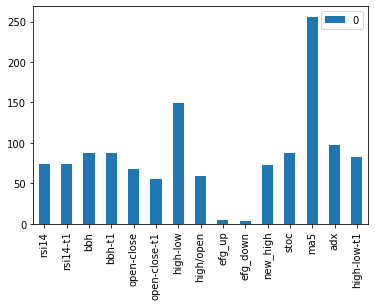

In [8]:
pd.DataFrame(model.feature_importances_, X_test.columns).plot.bar()

In [9]:
df_test['signal'] = model.predict(X_test)

In [10]:
result = dpt.Backtest.trade_simulation(df_test.copy(), commission=80, digit=1, pip_profit=30)

In [11]:
result.pnl.mean()/result.pnl.std()

0.02047573742869958

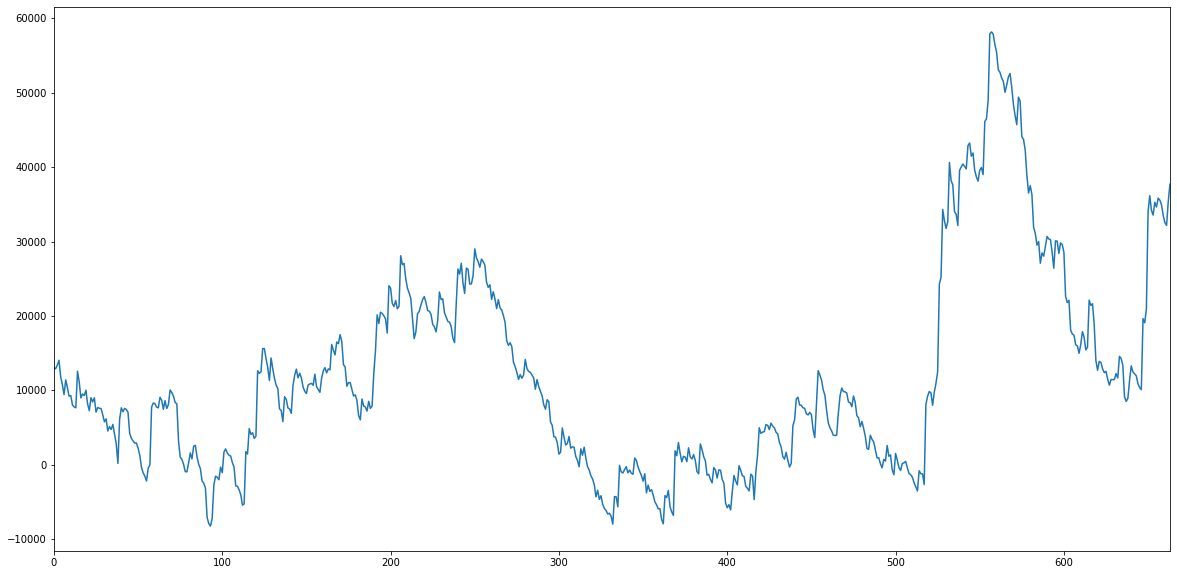

In [12]:
(result.equity + 10000).plot(figsize=(20,10))

In [13]:
result.set_index('open_time', drop=False, inplace=True)

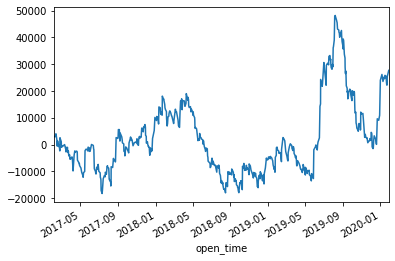

In [14]:
result.equity.plot()

In [15]:
result

,type,open_time,open_price,close_time,close_price,length,pnl,equity
open_time,,,,,,,,
2017-02-03 20:00:00,1,2017-02-03 20:00:00,1220.594,2017-02-07 04:00:00,1230.862,9,3000.4,3000.4
2017-02-07 12:00:00,1,2017-02-07 12:00:00,1234.860,2017-02-08 00:00:00,1234.874,3,-75.8,2924.6
2017-02-08 08:00:00,1,2017-02-08 08:00:00,1237.154,2017-02-09 08:00:00,1238.996,6,472.6,3397.2
2017-02-10 08:00:00,1,2017-02-10 08:00:00,1226.840,2017-02-13 00:00:00,1229.295,5,656.5,4053.7
2017-02-13 08:00:00,1,2017-02-13 08:00:00,1230.336,2017-02-13 12:00:00,1223.165,1,-2231.3,1822.4
...,...,...,...,...,...,...,...,...
2020-01-21 20:00:00,1,2020-01-21 20:00:00,1556.637,2020-01-22 00:00:00,1552.129,1,-1432.4,23508.3
2020-01-22 12:00:00,1,2020-01-22 12:00:00,1557.145,2020-01-23 04:00:00,1554.240,4,-951.5,22556.8
2020-01-23 12:00:00,1,2020-01-23 12:00:00,1562.779,2020-01-24 00:00:00,1561.804,3,-372.5,22184.3
